In [ ]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install \
  "langchain" \
  "langchain-community" \
  "langchain-experimental" \
  "langchain-groq" \
  "langgraph" \
  "openmeteo-requests" \
  "requests-cache" \
  "retry-requests" \
  numpy \
  pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.9 MB/s eta 0:00:00


In [ ]:
#del workflow

In [ ]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

In [ ]:
# --- Imports ---
import os
import pandas as pd
import requests
from datetime import datetime
from typing import Dict # Changed from dict for clarity

# Langchain/LangGraph specific
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver # Good practice for state management
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Dict, List, Any # Make sure List and Any are imported
#from langchain_experimental.utilities import PythonREPL
from langchain.agents import initialize_agent, Tool
from langchain.agents.agent_types import AgentType
from langgraph.prebuilt import ToolNode


# Open Meteo specific
from openmeteo_requests import Client
import pprint # Import the pretty-print module

In [ ]:
@tool
def get_lat_lon(city_name: str):
    """This tool is used to get the latitude and longitude of a city."""

    api_key = "c269e5bf9a8635a7a98a20b5fa1c9d3a"

    url = f"http://api.openweathermap.org/data/2.5/weather?q={city_name}&appid={api_key}"
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
        data = response.json()
        if 'coord' in data and 'lat' in data['coord'] and 'lon' in data['coord']:
             #return {"lat": data['coord']['lat'], "lon": data['coord']['lon']}
             return {
                        "city": city_name,
                        "lat": data['coord']['lat'],
                        "lon": data['coord']['lon']
                    }
        else:
             raise ValueError(f"Could not parse lat/lon from response for {city_name}. Response: {data}")
    except requests.exceptions.RequestException as e:
        raise ValueError(f"API request failed for {city_name}: {e}")
    except Exception as e:
        raise ValueError(f"Error getting lat/lon for {city_name}: {e}")

In [ ]:
@tool
def get_city_weather(coords: Dict[str, float]) -> Dict:
    """Returns the current weather data as a dictionary for given coordinates.
    Expects a dictionary input with 'lat' and 'lon' keys, e.g., {'lat': 25.85, 'lon': 85.7833}."""

    apikey = "5d607cc20903d15f6fee1c3b94048253"
    lat = coords['lat']
    lon = coords['lon']

    url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={apikey}"

    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes
        weather_data = response.json()
        return weather_data # Return the full JSON data for now
    except requests.exceptions.RequestException as e:
        raise ValueError(f"API request failed for lat={lat}, lon={lon}: {e}")
    except Exception as e:
        # Catch other potential errors like JSON decoding
        raise ValueError(f"Error getting weather for lat={lat}, lon={lon}: {e}")

In [ ]:
# Wrap it as a LangChain tool
# If you do not use @tool decorater , in thar case you need to wrap all your function into Tool class, for python REPL you need to manditory need to do it.

# --- Tool definitions ---
# latlon_tool = Tool(
#     name="GetLatLon",
#     func=get_lat_lon,
#     description="Use this tool to fetch latitude and longitude of a given city. Returns a dictionary like {'city': '...', 'lat': ..., 'lon': ...}." # Clarify output
# )

# # Update weather_tool description
# weather_tool = Tool(
#     name="GetWeather",
#     func=get_city_weather,
#     description="Use this tool to fetch current weather using coordinates. Input must be a dictionary containing 'lat' and 'lon' keys, like the output of GetLatLon." # IMPORTANT: Update description
# )

In [ ]:
# Add Python REPL tool for analysis
python_tool = PythonREPL()

In [ ]:
repl_tool = Tool(
    name="python_tool",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_tool.run,
)

In [ ]:
# --- LLM and Tools Setup ---
groq_api_key = "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"

# Use a capable model for tool usage like Mixtral or Llama3
llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama3-70b-8192"
)

In [ ]:
# tools=[latlon_tool,weather_tool, repl_tool]
tools=[get_lat_lon,get_city_weather, repl_tool]
llm_with_tool=llm.bind_tools(tools, tool_choice="auto")

tool_node=ToolNode(tools=tools)

In [ ]:
def call_model(state:MessagesState):
  question=state["messages"]
  response=llm_with_tool.invoke(question)
  return {"messages":[response]}

def router_function(state: MessagesState):
    messages = state["messages"]
    last_msg = messages[-1]

    # If tool call was returned, execute tool
    if last_msg.tool_calls:
        return "tools"

    return END

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("assistant",call_model)
workflow.add_node("myweathertool",tool_node)

workflow.add_edge(START, "assistant")
workflow.add_conditional_edges(
    "assistant",
    router_function,
    {"tools":"myweathertool", END:END}
)
# After defining the conditional edge from assistant
workflow.add_edge("myweathertool", "assistant")

app=workflow.compile()

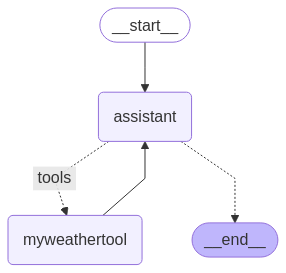

In [ ]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
result=app.invoke({"messages":"Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, and then use those values to fetch the average temperature using the GetWeather tool."})
pprint.pprint(result) # Use pprint for readable output

{'messages': [HumanMessage(content='Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, and then use those values to fetch the average temperature using the GetWeather tool.', additional_kwargs={}, response_metadata={}, id='0d09116e-3f61-4f6d-a1e4-b94df7403e9c'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7cr4', 'function': {'arguments': '{"city_name":"Samastipur"}', 'name': 'get_lat_lon'}, 'type': 'function'}, {'id': 'call_qex8', 'function': {'arguments': '{"coords":{}}', 'name': 'get_city_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 1243, 'total_tokens': 1323, 'completion_time': 0.228571429, 'prompt_time': 0.041086984, 'queue_time': 0.20877562600000002, 'total_time': 0.269658413}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-93d1ab48-da00-4b5c-a4c5-c7a47c494c2d-0', tool

In [ ]:
result = app.invoke({
  "messages": "Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, then use those values to fetch the weather data using the GetWeather tool. From the result, extract the temperature from main[\"temp\"] and convert it from Kelvin to Celsius using the Python tool."
})
pprint.pprint(result)


{'messages': [HumanMessage(content='Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, then use those values to fetch the weather data using the GetWeather tool. From the result, extract the temperature from main["temp"] and convert it from Kelvin to Celsius using the Python tool.', additional_kwargs={}, response_metadata={}, id='585e6e0c-ab6e-4576-9eec-ed002725af83'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zgyh', 'function': {'arguments': '{"city_name":"Samastipur"}', 'name': 'get_lat_lon'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 206, 'prompt_tokens': 1266, 'total_tokens': 1472, 'completion_time': 0.588571429, 'prompt_time': 0.041574259, 'queue_time': 0.222167632, 'total_time': 0.630145688}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a588d404-a328-48f2-bcb1-ba87ee7b7839-0', tool_calls=[{'n

In [ ]:
result = app.invoke({
  "messages": "Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, then use those values to fetch the weather data using the GetWeather tool. From the result, extract 'sys.sunrise' and 'sys.sunset' and convert both values from Unix timestamp to IST (Indian Standard Time) using the Python tool. Display the output in 'HH:MM:SS' format."
})
pprint.pprint(result)

{'messages': [HumanMessage(content="Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, then use those values to fetch the weather data using the GetWeather tool. From the result, extract 'sys.sunrise' and 'sys.sunset' and convert both values from Unix timestamp to IST (Indian Standard Time) using the Python tool. Display the output in 'HH:MM:SS' format.", additional_kwargs={}, response_metadata={}, id='9d47642b-6dbe-4528-95ea-b9decdce1c2a'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bmt6', 'function': {'arguments': '{"city_name":"Samastipur"}', 'name': 'get_lat_lon'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 294, 'prompt_tokens': 2636, 'total_tokens': 2930, 'completion_time': 0.84, 'prompt_time': 0.095201965, 'queue_time': -0.868213496, 'total_time': 0.935201965}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': Non

In 1st HumanMessage, user is asking prompt,

in 2nd AIMessage, assistant takes/decides on argument and decides to pass it to tool get_lat_lon and the 3 tool available.

in 3rd ToolMessage, output is generated by theget_lat_lon tool as {"city": "Samastipur", "lat": 25.85, "lon": 85.7833}

If you look at 4th Message i.e AIMessage control again goes to assistant, it is taking arguments as coordinates and passing it to function/tool get_city_weather now.


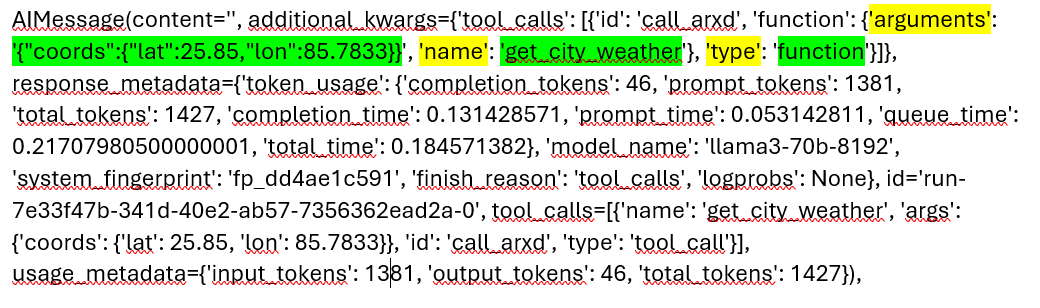

So 5th ToolMessage, get_city_weather runs and generates its output

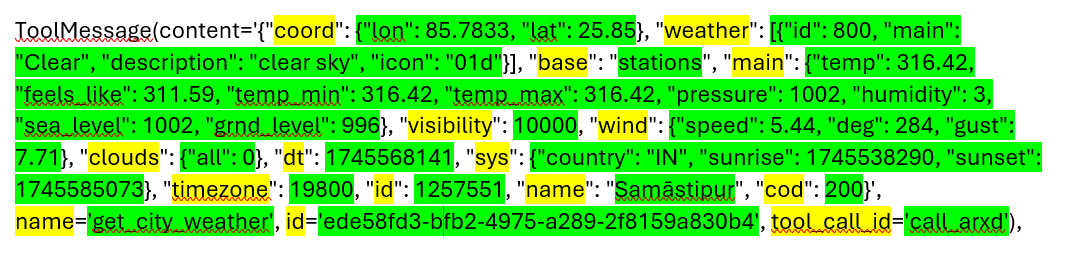

control again passed to assistant and genrated 6th AI Message, now assistant is generating argument keeping in mind the prompt asked i.e timing ...so LLM generting the python code and will pass it as argument to pytho repl python tool (i.e python compiler) to genete the answer to the prompt

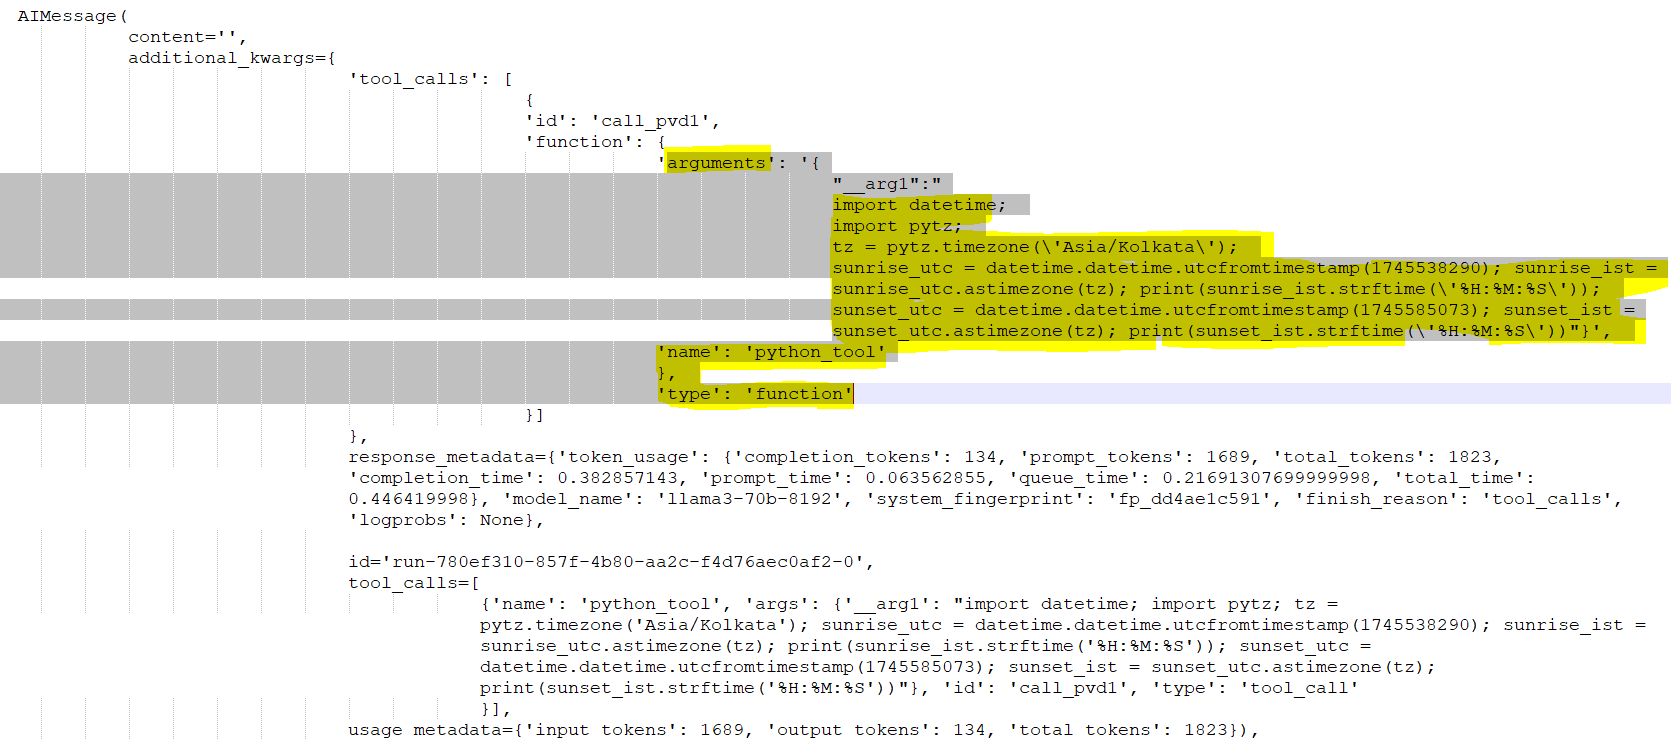

7th ToolMessage , so python repl tool , generate outputs which is asked in prompt

ToolMessage(content='05:14:50\n18:14:33\n', name='python_tool', id='73060324-7782-4d84-8020-7f102f6d3ee2', tool_call_id='call_pvd1'),

 control again goes to ai assistant in 8th AIMessage, and assistant gives final answer.

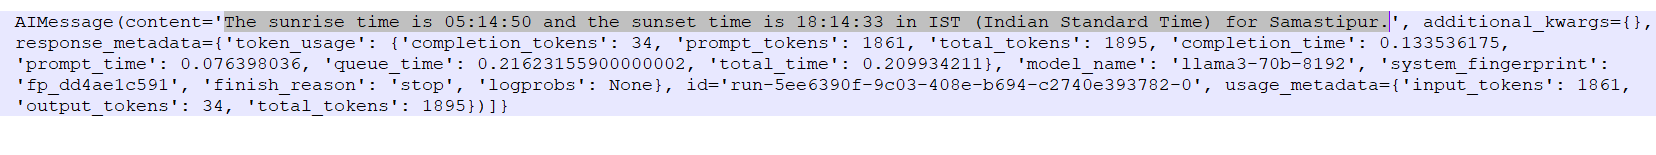

# some other promts to invoke

In [ ]:
result = app.invoke({
  "messages": "Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, then use those values to fetch the weather data using the GetWeather tool. From the result, summarize the weather condition in a sentence like: 'Today in Samastipur, the sky is clear with a temperature of XX°C', replacing XX with the actual temperature in Celsius and using the weather description from the data."
})
pprint.pprint(result)
'''
In below output you can see that only 2 tools(get coordinates and get weather) is called and assistant genereates the output. no call to python repl tool, because it is not necessary keeping in view what prompt query is asked for
'''

{'messages': [HumanMessage(content="Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, then use those values to fetch the weather data using the GetWeather tool. From the result, summarize the weather condition in a sentence like: 'Today in Samastipur, the sky is clear with a temperature of XX°C', replacing XX with the actual temperature in Celsius and using the weather description from the data.", additional_kwargs={}, response_metadata={}, id='9cc8e7f5-8eb8-41cb-8f94-4a7d4651796b'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_33va', 'function': {'arguments': '{"city_name":"Samastipur"}', 'name': 'get_lat_lon'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 161, 'prompt_tokens': 2615, 'total_tokens': 2776, 'completion_time': 0.46, 'prompt_time': 0.091658925, 'queue_time': -0.295271112, 'total_time': 0.551658925}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'f

In [ ]:
result = app.invoke({
  "messages": "Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, then use those values to fetch the weather data using the GetWeather tool. From the result, convert the current temperature (main.temp), minimum temperature (main.temp_min), and maximum temperature (main.temp_max) from Kelvin to both Celsius and Fahrenheit, and display all values."
})
pprint.pprint(result)
'''
ultimate case of halucination here, in 4th message (ToolMessage), there is error, but still assistant generates final output.
'''

{'messages': [HumanMessage(content='Get the coordinates (lat/lon) of the city Samastipur using the GetLatLon tool, then use those values to fetch the weather data using the GetWeather tool. From the result, convert the current temperature (main.temp), minimum temperature (main.temp_min), and maximum temperature (main.temp_max) from Kelvin to both Celsius and Fahrenheit, and display all values.', additional_kwargs={}, response_metadata={}, id='5dde8d97-8155-4558-b7be-b2e7243d2b8b'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_t5pg', 'function': {'arguments': '{"city_name":"Samastipur"}', 'name': 'get_lat_lon'}, 'type': 'function'}, {'id': 'call_pjg5', 'function': {'arguments': '{"coords":{}}', 'name': 'get_city_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 116, 'prompt_tokens': 2620, 'total_tokens': 2736, 'completion_time': 0.331428571, 'prompt_time': 0.100256218, 'queue_time': -0.342367496, 'total_time':

# Just to check what json we are getting from api call

In [ ]:
coords={"lat":25.85,"lon":85.7833}

def get_city_weather_1(coords: Dict[str, float]) -> Dict:
    """Returns the current weather data as a dictionary for given coordinates.
    Expects a dictionary input with 'lat' and 'lon' keys, e.g., {'lat': 25.85, 'lon': 85.7833}."""

    apikey = "5d607cc20903d15f6fee1c3b94048253"
    lat = coords['lat']
    lon = coords['lon']

    url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={apikey}"

    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes
        weather_data = response.json()
        return weather_data # Return the full JSON data for now
    except requests.exceptions.RequestException as e:
        raise ValueError(f"API request failed for lat={lat}, lon={lon}: {e}")
    except Exception as e:
        # Catch other potential errors like JSON decoding
        raise ValueError(f"Error getting weather for lat={lat}, lon={lon}: {e}")

pprint.pprint(get_city_weather_1(coords))

{'base': 'stations',
 'clouds': {'all': 0},
 'cod': 200,
 'coord': {'lat': 25.85, 'lon': 85.7833},
 'dt': 1745563605,
 'id': 1257551,
 'main': {'feels_like': 310.41,
          'grnd_level': 997,
          'humidity': 4,
          'pressure': 1004,
          'sea_level': 1004,
          'temp': 314.53,
          'temp_max': 314.53,
          'temp_min': 314.53},
 'name': 'Samāstipur',
 'sys': {'country': 'IN', 'sunrise': 1745538290, 'sunset': 1745585073},
 'timezone': 19800,
 'visibility': 10000,
 'weather': [{'description': 'clear sky',
              'icon': '01d',
              'id': 800,
              'main': 'Clear'}],
 'wind': {'deg': 287, 'gust': 7.99, 'speed': 4.18}}


# Key **Learning**

💡 What is Python REPL in LangChain?

The Python REPL Tool is like giving your agent a Python interpreter(to run python code). So instead of the agent just "talking", it can run Python code to analyze data, calculate values, or format things intelligently.

Uses the Python REPL Tool to analyze and summarize the result.

🧠 How the Agent(assist) Uses the REPL Tool (Big Picture)
You ask:

"Get the weather and tell me the temperature in Celsius and if it’s raining."

The agent:

Reads your question.

Realizes:
🧩 “Hmm, I need to convert temperature from Kelvin to Celsius and extract rain info.”

Calls the weather API tool to get raw JSON.

The agent thinks:

"Okay! Now I’ve got the JSON. I need to write some Python code(assist/llm itself writes it and pass it to REPL i.e python interpretor) to compute the Celsius temp and check the rain."

The agent calls the Python REPL Tool to run the python code, output generated is passed to assistant and assistant finally answers the prompt.
